### automl efficientdet 다운로드 및 설치

In [1]:
!git clone --depth 1 https://github.com/google/automl

Cloning into 'automl'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 176 (delta 16), reused 65 (delta 0), pack-reused 0
Receiving objects: 100% (176/176), 13.77 MiB | 32.64 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!python --version

Python 3.10.12


In [3]:
!cd /content/automl/efficientdet; pip install -q -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


In [4]:
import os
import sys
import tensorflow.compat.v1 as tf

sys.path.append('/content/automl/efficientdet')

import hparams_config
from tf2 import anchors
from model_inspect import ModelInspector

###  PASCAL V0C 2007 데이터 세트 다운로드

In [5]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null 2>&1

--2023-11-17 07:24:37--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2023-11-17 07:24:37--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   107MB/s    in 4.1s    

2023-11-17 07:24:42 (107 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [6]:
!ls -lia /content/VOCdevkit/VOC2007/Annotations/*.xml| wc -l

5011


### 학습 데이터와 검증 데이터를 tfrecord 형태로 변환
* create_pascal_tfrecord.py를 이용하여 XML 포맷의 Annotation을 tfrecord로 변환.
* create_pascal_tfrecord.py 는 ImageSet 디렉토리에 위치한 train.txt를 읽어서 해당 xml과 image를 train용 tfrecord로 변환. val.txt를 읽어서 valid용 tfrecord로 변환.
* train과 val용 각각 약 2500여개의 image/xml를 100개씩 하나의 tfrecord로 생성.

In [7]:
!mkdir -p /content/tfrecord/train
!mkdir -p /content/tfrecord/val

# --output_path=/content/tfrecord/train/pascal에서 directory는 /content/tfrecord/train/ 까지, 뒤의 pascal을 tfrecord파일의 prefix임..
!cd /content/automl/efficientdet; PYTHONPATH="/content/automl/efficientdet:$PYTHONPATH" python dataset/create_pascal_tfrecord.py  \
    --data_dir=/content/VOCdevkit --year=VOC2007 --set=train --output_path=/content/tfrecord/train/pascal

!cd /content/automl/efficientdet; PYTHONPATH="/content/automl/efficientdet:$PYTHONPATH" python dataset/create_pascal_tfrecord.py  \
    --data_dir=/content/VOCdevkit --year=VOC2007 --set=val --output_path=/content/tfrecord/val/pascal

2023-11-17 07:24:49.730456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 07:24:49.730512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 07:24:49.730550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 07:24:52.165637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I1117 07:24:58.195243 136578566074368 create_pascal_tfrecord.py:254] Writing to output directory: /content/tfrecord/train
I1117 07:24:58.210764 136578566074368 create_pascal_tfrecord.py:287] Reading from PASCAL VOC2007 dataset.
I1117 07:2

### Train용 config 설정.
* 학습을 위한 다양한 설정을 config로 저장. model은 efficientdet-d0 로 적용.

In [8]:
# epochs시마다 학습된 weight파일을 저장한 디렉토리 Google drive로 설정.
# Google Drive 접근을 위한 Mount 적용.
import os, sys
from google.colab import drive

drive.mount('/content/gdrive')

# soft link로 Google Drive Directory 연결.
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
!mkdir -p /mydrive/CV_basic/DLCV/Section13

Mounted at /content/gdrive
'17기 선제적 체크인.gsheet'		    sc21x_18_g2.csv
'17기 커리어톡 사전질문.gsheet'		   'sc21x_v2 (1).csv'
'17기 프로젝트 도메인.gsheet'		    sc21x_v2.csv
'[18기] 섹션2 프로젝트 채점 시트.gsheet'    sc21x_v3.csv
'18기 스챌 점수.gsheet'			    sc22x_18.csv
 1주차_시연영상.mp4			    sc22x_18_final.csv
'84709070526 - Poll Report.gsheet'	    sc22x_18_g2.csv
'84709070526_RegistrationReport (18).csv'  'sc22x_v2 (1).csv'
 AI_camp_data				   'sc22x_v2 (2).csv'
'Colab Notebooks'			    sc22x_v2.csv
 CV_basic				    sc22x_v3.csv
 Day4.mp4				    sc23x_18_final.csv
 Day4_실습녹화본.mp4			   'sc23x_18_g2 (1).csv'
 discussion_18.csv			    sc23x_18_g2.csv
 discussion_satisfaction_18.gsheet	    sc23x_v1.csv
 groups2.csv				   'sc23x_v2 (1).csv'
'N221 Tree Based Model.gslides'		   'sc23x_v2 (2).csv'
'N222 Boosting.gslides'			    sc23x_v2.csv
'N223 Preprocessing.gslides'		    sc23x_v3.csv
'N224 Model Tuning.gslides'		    TP2_템플릿_일부.gslides
 NLP_basic

In [9]:
config = hparams_config.get_detection_config('efficientdet-d0')
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [21]:
class TRAIN_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  strategy = '' # tpu, 여러개의 GPU들, 단일 GPU 일때 학습 strategy 설정.
  model_dir = '/mydrive/CV_basic/DLCV/Section13/model_trained' # 학습된 모델이 저장될 위치
  pretrained_ckpt = '/content/efficientdet-d0'
  hparams = 'num_classes=20,moving_average_decay=0,mixed_precision=true' # 나눠서 써도되는데 귀찮아서 한번에 씀.
  # moving_average_decay를 0으로 안 하면 에러가 남

  use_xla = False
  use_fake_data = False
  batch_size = 8
  eval_samples = 5000 # evaluation image 데이터 갯수
  steps_per_execution = 1 # ModelCheckPoint의 save_freq 를 숫자로 설정할 경우 사용.
  num_examples_per_epoch = 2500 # 1 epochs 시 적용하는 이미지 개수
  num_epochs = 5 # epochs 횟수. 오래 걸리니까 5번만
  train_file_pattern = '/content/tfrecord/train/pascal-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식.
  val_file_pattern = '/content/tfrecord/val/pascal-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식.
  val_json_file = None # optional coco validation json
  mode = 'traineval' # train만 적용 또는 train과 eval함께 적용(traineval)

  num_cores = 2 # tpu 8 일때 적용.
  tpu = None
  gcp_project = None
  tpu_zone = None
  eval_master = ''
  eval_name = None
  tf_random_seed = 2023
  profile = False
  debug = False

In [22]:
# 강의영상에는 from keras import anchors 이지만 efficientdet 패키지의 keras 모듈이 tf2 로 변경됨.
from tf2.train import setup_model
import hparams_config

import utils
#from tf2 import tfmot
from tf2 import train_lib
from tf2 import util_keras

config = hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch = TRAIN_CFG.num_examples_per_epoch // TRAIN_CFG.batch_size

if tf.config.list_physical_devices('GPU'):
  ds_strategy = tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
  ds_strategy = tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)

#steps_per_execution은 ModelCheckpoint의 save_freq를 숫자로 설정할 시 적용. num_epochs, steps_per_epoch는 추후에 model.fit()에서 설정되지만, 여기서는 일단 값을 설정해야함.
params = dict(
      profile=TRAIN_CFG.profile,
      mode = TRAIN_CFG.mode,
      model_name=TRAIN_CFG.model_name,
      steps_per_execution=TRAIN_CFG.steps_per_execution,
      num_epochs = TRAIN_CFG.num_epochs,
      model_dir=TRAIN_CFG.model_dir,
      steps_per_epoch=steps_per_epoch,
      strategy=TRAIN_CFG.strategy,
      batch_size=TRAIN_CFG.batch_size,
      tf_random_seed=TRAIN_CFG.tf_random_seed,
      debug=TRAIN_CFG.debug,
      val_json_file=TRAIN_CFG.val_json_file,
      eval_samples=TRAIN_CFG.eval_samples,
      num_shards=ds_strategy.num_replicas_in_sync
      )

config.override(params, True)

# image size를 tuple 형태로 변환. 512는 (512, 512)로 '1920x880' 은 (1920, 880) 으로 변환.
config.image_size = utils.parse_image_size(config.image_size)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
batch_size: 8
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
eval_samples: 5000
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 512
- 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instan

### Model 생성
* Config를 기반으로 EfficientDet d0 모델을 생성
* Coco Pretrained 파일을 다운로드 한 뒤 이 checkpoint파일의 weight를 생성한 d0 모델로 로딩

In [15]:
import utils
# 강의영상에는 from keras import anchors 이지만 efficientdet 패키지의 keras 모듈이 tf2 로 변경됨.
#from tf2 import tfmot
from tf2 import train_lib
from tf2 import util_keras
# P100 GPU Card에서는 아래 수행하지 말것. V100 GPU 시에는 mixed_float16으로 mixed_precision 설정.
#precision = utils.get_precision(config.strategy, config.mixed_precision)
#policy = tf.keras.mixed_precision.Policy(precision)
#tf.keras.mixed_precision.set_global_policy(policy)

In [23]:
MODEL = 'efficientdet-d0'

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

Use model in /content/efficientdet-d0


In [24]:
# 강의영상에는 from keras import anchors 이지만 efficientdet 패키지의 keras 모듈이 tf2 로 변경됨.
from tf2 import train_lib
from tf2 import train

# 20개의 class를 가진 efficientdet d0 모델을 생성.
model = train_lib.EfficientDetNetTrain(config=config)
model = train.setup_model(model, config)

# 만약 pretrained 모델이 있으면, 해당 checkpoint weight를 모델로 로딩. 이때 classification layer는 제외.
#class TRAIN_CFG: pretrained_ckpt = '/content/efficientdet-d0'
if TRAIN_CFG.pretrained_ckpt:
  ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
  util_keras.restore_ckpt(
      model,
      ckpt_path,
      config.moving_average_decay,
      exclude_layers=['class_net']) # efficientdet은 coco로 학습되어있으니까 class_net을 가져오면 안 됨. coco는 class가 80개
      # Pascal은 20개

train.init_experimental(config)

model.summary()

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatu  multiple                  20800     
 reMap)                                                          
                                                                 
 resample_p7 (ResampleFeatu  multiple                  0         
 reMap)                                                          
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  30324     
                                                                 
 box_net (BoxNet)            multiple                  20964     


### 학습과 검증용 Dataset을 생성하고, Train 수행.
* 학습과 검증 데이터용 dataset 생성을 위한 get_dataset() 함수 생성.

In [25]:
'''
Class TRAIN_CFG:
  train_file_pattern = '/content/tfrecord/train/pascal-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식.
  val_file_pattern = '/content/tfrecord/val/pascal-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식.
'''

import dataloader

def get_dataset(is_training, config):
  # is_training이 True이면 TRAIN_CFG의 train_file_pattern, 그렇지 아니면 val_file_pattern
  file_pattern = (
    TRAIN_CFG.train_file_pattern
    if is_training else TRAIN_CFG.val_file_pattern)
  if not file_pattern:
    raise ValueError('No matching files.')

  return dataloader.InputReader( #여기에 파일패턴을 넣어줘야 모델이 tfrecord 형태로 학습 할 수 있음
    file_pattern,
    is_training=is_training,
    use_fake_data=TRAIN_CFG.use_fake_data,
    max_instances_per_image=config.max_instances_per_image,
    debug=TRAIN_CFG.debug)(
        config.as_dict())

In [26]:
import pandas as pd

#  train.txt와 val.txt를 읽어서 train과 val 용 image 건수를 구함
train_df = pd.read_csv('/content/VOCdevkit/VOC2007/ImageSets/Main/train.txt', sep=' ',
                       header=None, names=['file_id'], dtype={'file_id':str})
val_df = pd.read_csv('/content/VOCdevkit/VOC2007/ImageSets/Main/val.txt', sep=' ',
                       header=None, names=['file_id'], dtype={'file_id':str})

train_images_num = train_df.shape[0]
val_images_num = val_df.shape[0]
print(train_images_num, val_images_num)

train_df.head()

2501 2510


,file_id
0,000012
1,000017
2,000023
3,000026
4,000032


In [27]:
import tensorflow as tf
from tf2 import train_lib
from tf2 import train

# 위에서 했던걸 함수로 만들자
# config에 기반하여 모델을 생성하고 pretrained weight를 로딩하는 함수 생성.
def get_efficientdet_model(config):
  model = train_lib.EfficientDetNetTrain(config=config)
  model = train.setup_model(model, config)

  if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net'])

  train.init_experimental(config)
  return model

model = get_efficientdet_model(config)
model.summary()

/tmp/__autograph_generated_file3csj8rlu.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
/content/automl/efficientdet/utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatu  multiple                  20800     
 reMap)                                                          
                                                                 
 resample_p7 (ResampleFeatu  multiple                  0         
 reMap)                                                          
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  30324     
                                                                 
 box_net (BoxNet)            multiple                  20964     


In [28]:
from tf2 import train
import numpy as np

# config에 설정된 steps_per_epoch, num_epochs는 무시하고 여기서 새로 설정.
# steps_per_epoch는 전체 학습데이터 이미지 건수//batch_size, val_steps_per_epoch는 전체 검증 데이터 이미지 건수//batch_size
tr_steps_per_epoch = train_images_num//config.batch_size
val_steps_per_epoch = val_images_num//config.batch_size
print('tr_steps_per_epoch:', tr_steps_per_epoch, 'val_steps_per_epoch:', val_steps_per_epoch)

#  config.mode가 traineval 또는 eval일 경우 검증 dataset 생성.
val_dataset = get_dataset(False, config) if 'eval' in config.mode else None
#callback은 config에 설정된 구성대로 생성. ModelCheckpoint는 epoch시마다, COCO Evaluation는 5회 epoch시마다 수행됨.
#config.save_freq = epoch;config.map_freq = 5
# 1 epoch시마다 P100에서 약 3분30초 걸림. 적절한 epochs 수 설정 필요.
model.fit(
    get_dataset(True, config),
    epochs=5,
    steps_per_epoch=tr_steps_per_epoch ,
    callbacks=train_lib.get_callbacks(config.as_dict(), val_dataset),
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch)

tf.keras.backend.clear_session()

tr_steps_per_epoch: 312 val_steps_per_epoch: 313
Epoch 1/15
312/312 [==============================] - ETA: 0s - det_loss: 86.4449 - cls_loss: 86.1789 - box_loss: 0.0053 - reg_l2_loss: 0.0954 - loss: 86.5403 - learning_rate: 0.0090 - gradient_norm: 3.1590
Epoch 1: saving model to /mydrive/CV_basic/DLCV/Section13/model_trained/ckpt-1
312/312 [==============================] - 272s 619ms/step - det_loss: 86.1715 - cls_loss: 85.9057 - box_loss: 0.0053 - reg_l2_loss: 0.0954 - loss: 86.2669 - learning_rate: 0.0090 - gradient_norm: 3.1562 - val_det_loss: 1.0369 - val_cls_loss: 0.7385 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0955 - val_loss: 1.1324
Epoch 2/15
312/312 [==============================] - ETA: 0s - det_loss: 0.8474 - cls_loss: 0.6424 - box_loss: 0.0041 - reg_l2_loss: 0.0955 - loss: 0.9429 - learning_rate: 0.0069 - gradient_norm: 2.5933
Epoch 2: saving model to /mydrive/CV_basic/DLCV/Section13/model_trained/ckpt-2
312/312 [==============================] - 190s 610ms/step - det

KeyboardInterrupt: ignored

### 학습된 모델 파일을 이용하여 Inference 수행.

In [29]:
import hparams_config

infer_config = hparams_config.get_efficientdet_config('efficientdet-d0')
print(infer_config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [30]:
infer_config = hparams_config.get_efficientdet_config('efficientdet-d0')
# config의 특정 항목을 update
infer_config.model_name = 'efficientdet-d0'
infer_config.model_dir = '/mydrive/CV_basic/DLCV/Section13/model_trained'
# infer_config의 num_classes는 20로 바뀌어야 함.
infer_config.num_classes =20
infer_config.is_training_bn = False
infer_config.nms_configs.score_thresh = 0.4
infer_config.nms_configs.max_output_size = 100

In [31]:
import inference
from tf2 import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

#### checkpoint name: /mydrive/CV_basic/DLCV/Section13/model_trained/ckpt-5
Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatu  multiple                  20800     
 reMap)                                                          
                                                                 
 resample_p7 (ResampleFeatu  multiple                  0         
 reMap)                                                          
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  30324     
                                                        

In [32]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [33]:
!mkdir -p /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2023-11-17 08:16:44--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2023-11-17 08:16:45 (12.6 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]

--2023-11-17 08:16:45--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7627

In [34]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

elapsed time: 5.721081733703613


In [35]:
labels_to_names =  {1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle', 6:'bus', 7:'car',
               8:'cat', 9:'chair', 10:'cow', 11:'diningtable', 12:'dog', 13:'horse',
               14:'motorbike', 15:'person', 16:'pottedplant', 17:'sheep', 18:'sofa', 19:'train',
               20:'tvmonitor'}

In [36]:
def get_detected_img(export_model, img_array, is_print=True):
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음.
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행.
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환.
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환.
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단.
    score = scores[0, i]

    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0]
    right = box[3]
    bottom = box[2]

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.8644
person: 0.7989
person: 0.7965
person: 0.7595
car: 0.4285
car: 0.4030
Detection 수행시간: 0.04 초


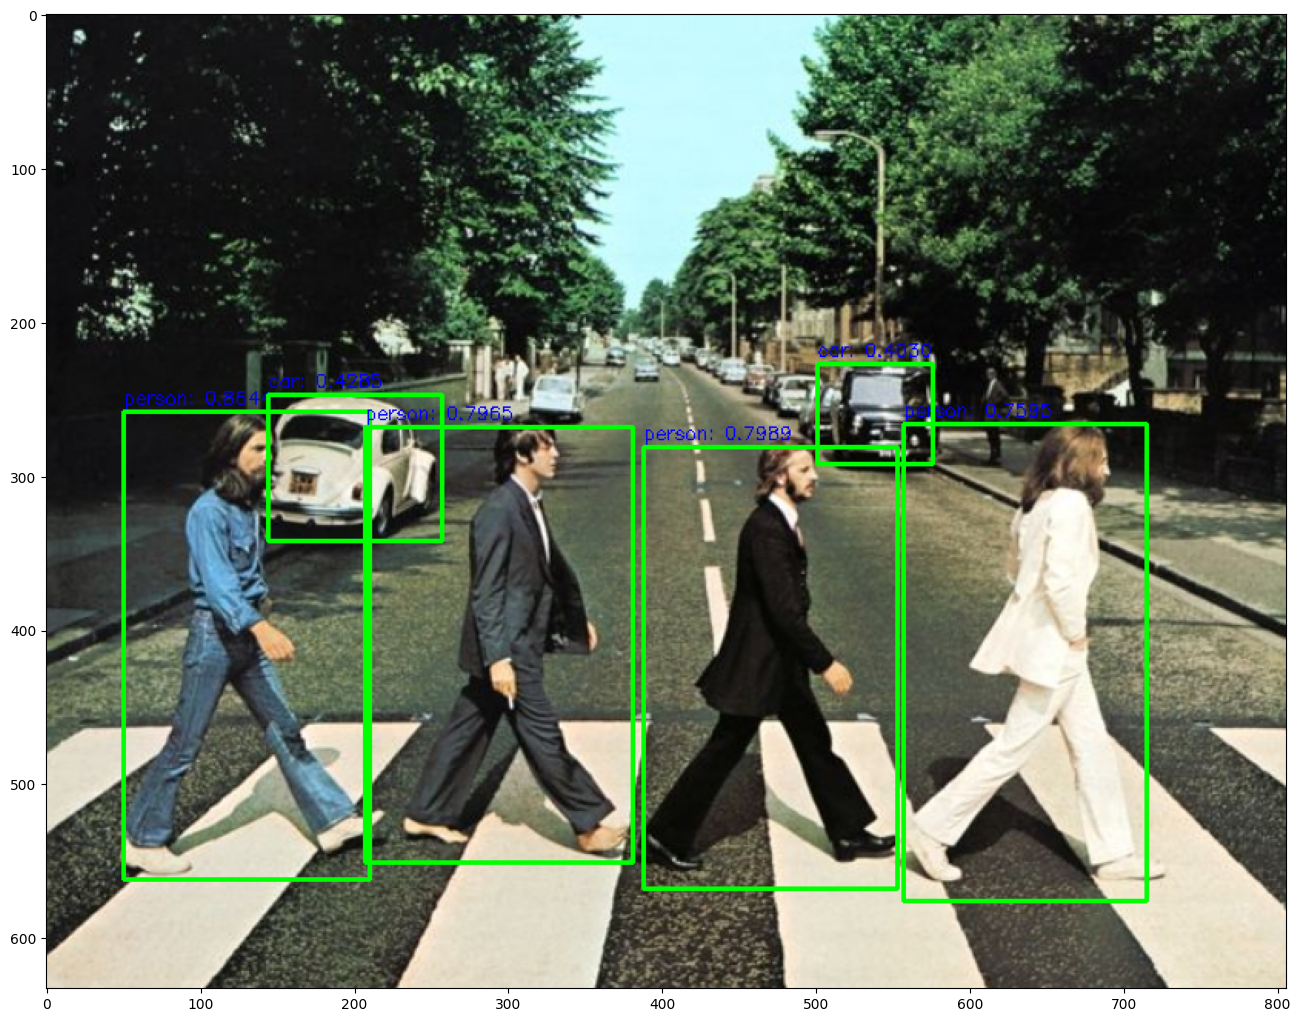

In [37]:
import cv2
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)